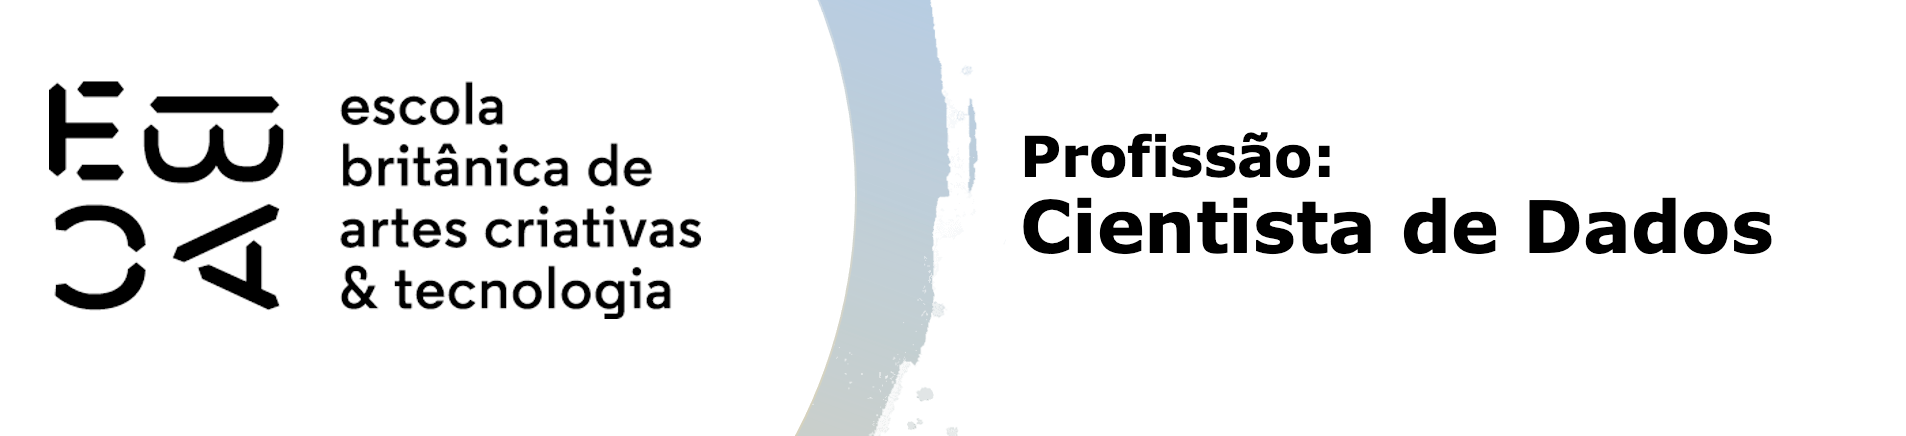

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t


df = pd.read_feather('../36 -  Descritiva IV - Visualização dos dados categorizados/credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [2]:
print(df.columns)
print(df.shape)

Index(['data_ref', 'index', 'sexo', 'posse_de_veiculo', 'posse_de_imovel',
       'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil',
       'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda', 'mau'],
      dtype='object')
(750000, 15)


In [3]:
df['data_ref'].value_counts()

2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: data_ref, dtype: int64

In [4]:
df1 = df.copy().drop(['index'], axis=1)
df_base = df1.loc[df1['data_ref']<='2015-12-01']
df_oot = df1.loc[df1['data_ref']>'2015-12-01']
print(df_base['data_ref'].value_counts())
print()
print(df_oot['data_ref'].value_counts())

2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
Name: data_ref, dtype: int64

2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: data_ref, dtype: int64


In [5]:
df_base_train = df_base.sample(frac = 0.7, replace = False, random_state = 12345).reset_index(drop=True)
df_base_test = df_base.sample(frac = 0.3, replace = False, random_state = 12345).reset_index(drop=True)

In [6]:
print(df_base_train.shape)
print(df_base_test.shape)
print (df_oot.shape)

(420000, 14)
(180000, 14)
(150000, 14)


In [7]:
print(420000+180000)
print(420000+180000+150000)

600000
750000


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [8]:
df_train = df_base_train.copy()

In [9]:
df_train.loc[df_train['idade']<=30, 'idade_cat'] = 'até 30'
df_train.loc[(df_train['idade']>30) & (df_train['idade']<=40), 'idade_cat'] = 'de 31 a 40'
df_train.loc[(df_train['idade']>40) & (df_train['idade']<=50), 'idade_cat'] = 'de 41 a 50'
df_train.loc[(df_train['idade']>50) & (df_train['idade']<=60), 'idade_cat'] = 'de 51 a 60'
df_train.loc[df_train['idade']>60, 'idade_cat'] = 'acima de 60'

In [10]:
df_train['tempo_emprego_cat'] = pd.cut(df_train.tempo_emprego, bins = 8, labels=['---|5.466','5.466---|10.815', '10.815---|16.164', 
                               '16.164---|21.512', '21.512---|26.861', '26.861---|32.21', '32.21---|37.558', '37.558---|42.907'])

In [11]:
df_train['renda_cat'] = pd.qcut(df_train.renda, q = 8, labels = ['161.859---|2804.89','2804.89---|4661.39', '4661.39---|6911.64',
                               '6911.64---|9889.29', '9889.29---|14194.21', '14194.21---|21650.04', '21650.04---|40580.67', '40580.67---|4083986.22'])

In [12]:
df_train['data_ref'] = df_train['data_ref'].astype(str)
df_train[['Ano', 'Mes', 'Dia']] = df_train['data_ref'].str.split('-', expand=True)
df_train['data_ref'] = df_train['Ano']+'-'+df_train['Mes']+'-'+df_train['Dia']
df_train.head()

,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,idade_cat,tempo_emprego_cat,renda_cat,Ano,Mes,Dia
0,2015-02-01,F,N,S,0,Assalariado,Médio,Casado,Governamental,56,10.082192,2.0,1731.25,False,de 51 a 60,5.466---|10.815,161.859---|2804.89,2015,02,01
1,2015-05-01,F,N,N,0,Empresário,Médio,Casado,Casa,27,2.512329,2.0,7290.55,False,até 30,---|5.466,6911.64---|9889.29,2015,05,01
2,2015-04-01,F,N,S,0,Assalariado,Médio,Casado,Casa,48,10.731507,2.0,12030.30,False,de 41 a 50,5.466---|10.815,9889.29---|14194.21,2015,04,01
3,2015-07-01,F,S,S,0,Assalariado,Superior incompleto,Casado,Casa,30,6.597260,2.0,42980.18,False,até 30,5.466---|10.815,40580.67---|4083986.22,2015,07,01
4,2015-01-01,F,N,S,2,Assalariado,Superior completo,Casado,Casa,53,30.120548,4.0,49990.12,False,de 51 a 60,26.861---|32.21,40580.67---|4083986.22,2015,01,01


In [13]:
print(f'A base de treino possui {df_train.data_ref.value_counts().sum()} linhas.')
print()
print(f'''O número de linhas em cada mês é: 
      {pd.DataFrame(df_train.data_ref.value_counts().sort_index())}''')

A base de treino possui 420000 linhas.

O número de linhas em cada mês é: 
                  data_ref
2015-01-01     34888
2015-02-01     34964
2015-03-01     35038
2015-04-01     35037
2015-05-01     34862
2015-06-01     34957
2015-07-01     34984
2015-08-01     35182
2015-09-01     34989
2015-10-01     35163
2015-11-01     34834
2015-12-01     35102


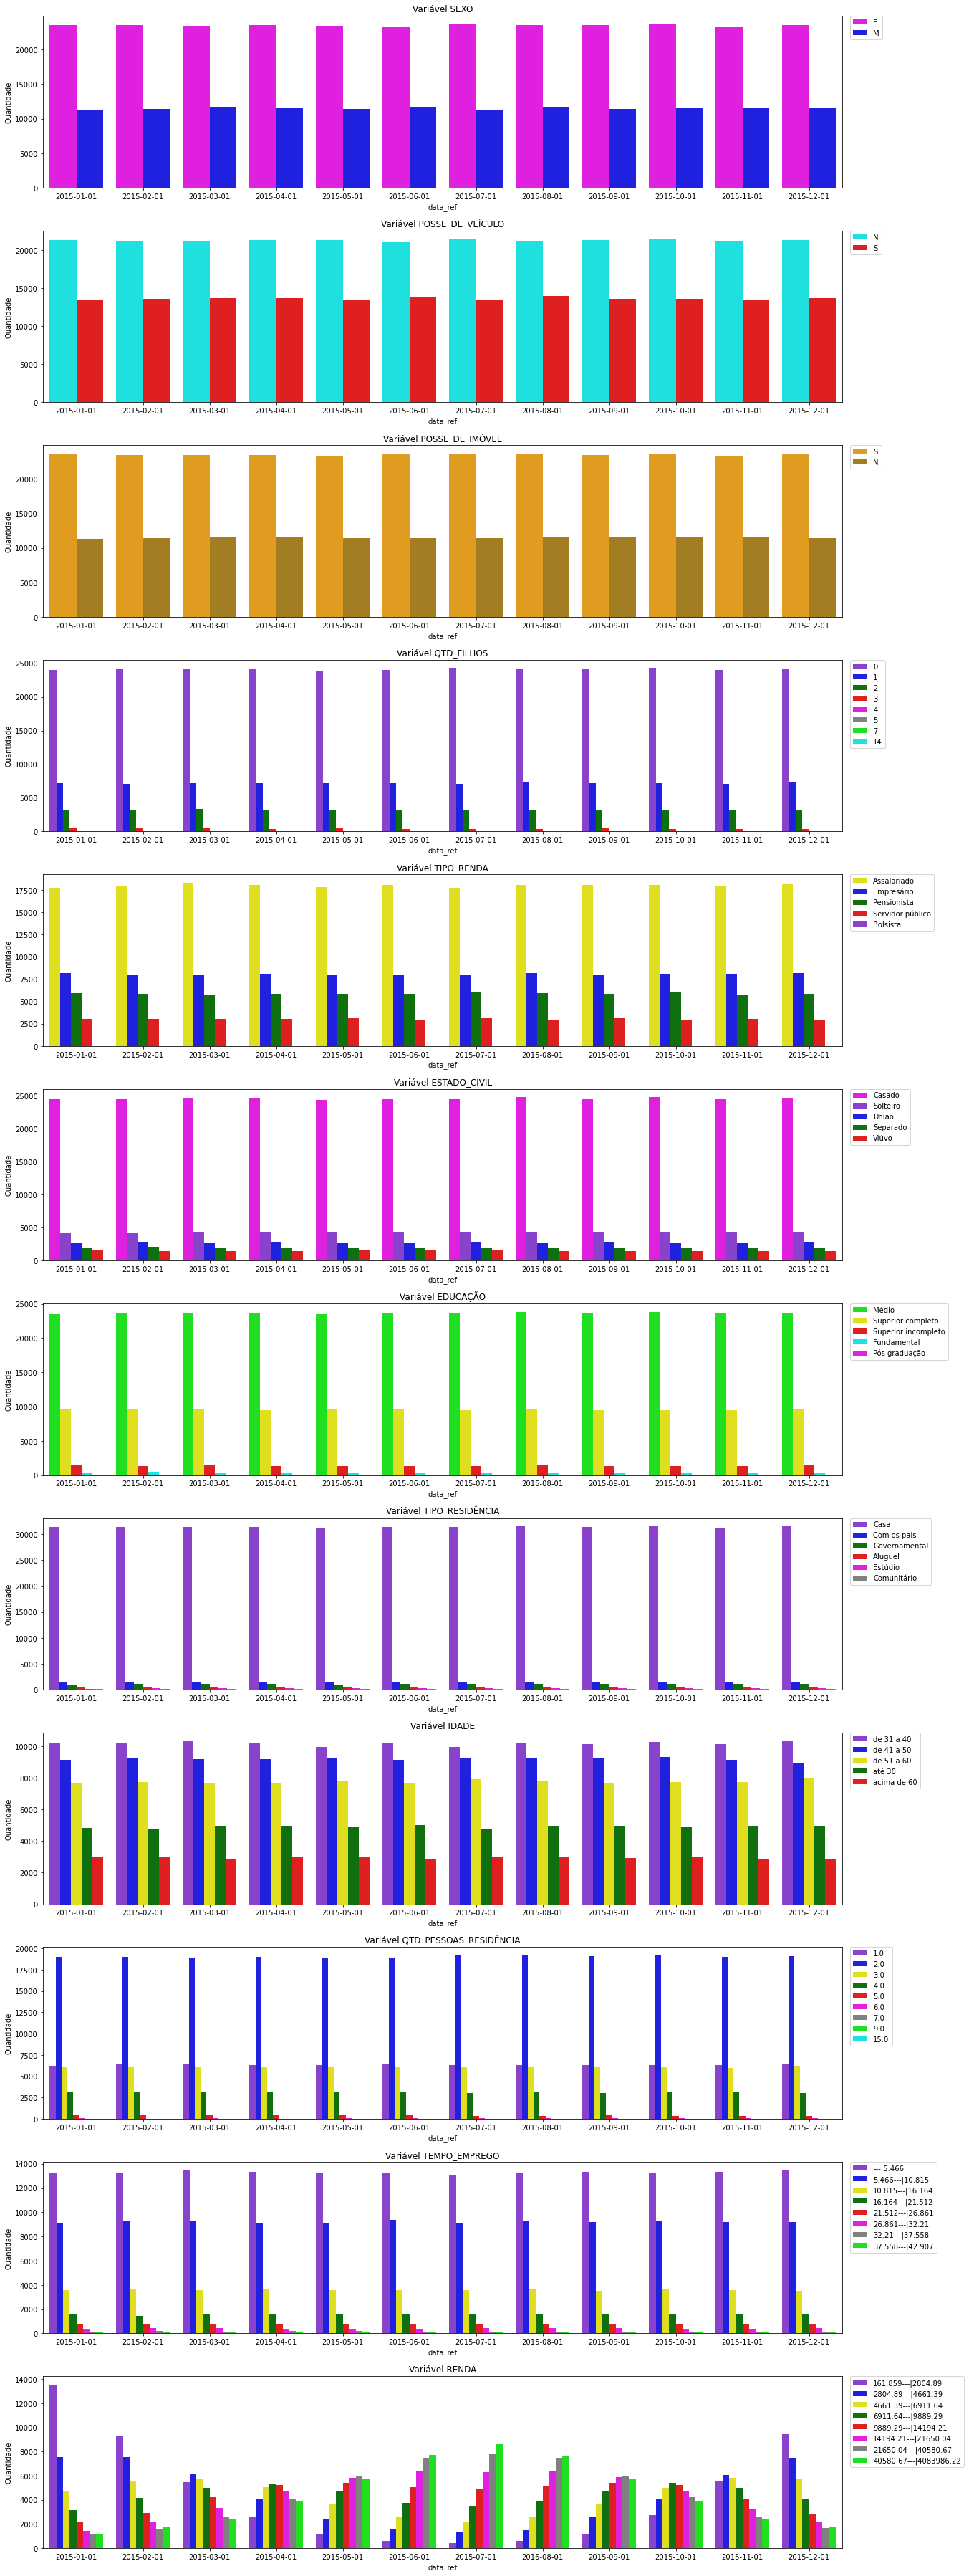

In [15]:
plt.rc('figure', figsize=(20,65))
fig, axes = plt.subplots(12)

ax = axes[0]
colors = ['magenta', 'blue']
sns.set_palette(sns.color_palette(colors))
dt = pd.DataFrame(df_train.groupby('data_ref')['sexo'].value_counts()).stack().reset_index()
sns.barplot(ax = axes[0], data = dt, x='data_ref', y= 0, hue = 'sexo')
ax.set_ylabel('Quantidade')
ax.set_title('Variável SEXO')
ax.legend(bbox_to_anchor = (1.01,1), loc='upper left', borderaxespad = 0)

ax = axes[1]
colors = ['aqua', 'red']
sns.set_palette(sns.color_palette(colors))
dt = pd.DataFrame(df_train.groupby('data_ref')['posse_de_veiculo'].value_counts()).stack().reset_index()
sns.barplot(ax = axes[1], data = dt, x='data_ref', y= 0, hue = 'posse_de_veiculo')
ax.set_ylabel('Quantidade')
ax.set_title('Variável POSSE_DE_VEÍCULO')
ax.legend(bbox_to_anchor = (1.01,1), loc='upper left', borderaxespad = 0)

ax = axes[2]
colors = ['orange', 'darkgoldenrod']
sns.set_palette(sns.color_palette(colors))
dt = pd.DataFrame(df_train.groupby('data_ref')['posse_de_imovel'].value_counts()).stack().reset_index()
sns.barplot(ax = axes[2], data = dt, x='data_ref', y= 0, hue = 'posse_de_imovel')
ax.set_ylabel('Quantidade')
ax.set_title('Variável POSSE_DE_IMÓVEL')
ax.legend(bbox_to_anchor = (1.01,1), loc='upper left', borderaxespad = 0)

ax = axes[3]
colors=['blueviolet','blue','green', 'red', 'magenta', 'grey', 'lime', 'aqua' ]
sns.set_palette(sns.color_palette(colors))
dt = pd.DataFrame(df_train.groupby('data_ref')['qtd_filhos'].value_counts()).stack().reset_index()
sns.barplot(ax = axes[3], data = dt, x='data_ref', y= 0, hue = 'qtd_filhos')
ax.set_ylabel('Quantidade')
ax.set_title('Variável QTD_FILHOS')
ax.legend(bbox_to_anchor = (1.01,1), loc='upper left', borderaxespad = 0)

ax = axes[4]
colors=['yellow','blue','green', 'red', 'blueviolet', 'grey', 'lime', 'aqua' ]
sns.set_palette(sns.color_palette(colors))
dt = pd.DataFrame(df_train.groupby('data_ref')['tipo_renda'].value_counts()).stack().reset_index()
sns.barplot(ax = axes[4], data = dt, x='data_ref', y= 0, hue = 'tipo_renda')
ax.set_ylabel('Quantidade')
ax.set_title('Variável TIPO_RENDA')
ax.legend(bbox_to_anchor = (1.01,1), loc='upper left', borderaxespad = 0)

ax = axes[5]
colors=['magenta', 'blueviolet','blue','green', 'red', 'yellow', 'grey', 'lime', 'aqua' ]
sns.set_palette(sns.color_palette(colors))
dt = pd.DataFrame(df_train.groupby('data_ref')['estado_civil'].value_counts()).stack().reset_index()
sns.barplot(ax = axes[5], data = dt, x='data_ref', y= 0, hue = 'estado_civil')
ax.set_ylabel('Quantidade')
ax.set_title('Variável ESTADO_CIVIL')
ax.legend(bbox_to_anchor = (1.01,1), loc='upper left', borderaxespad = 0)

ax = axes[6]
colors=['lime', 'yellow', 'red', 'cyan', 'magenta', 'grey' ]
sns.set_palette(sns.color_palette(colors))
dt = pd.DataFrame(df_train.groupby('data_ref')['educacao'].value_counts()).stack().reset_index()
sns.barplot(ax = axes[6], data = dt, x='data_ref', y= 0, hue = 'educacao')
ax.set_ylabel('Quantidade')
ax.set_title('Variável EDUCAÇÃO')
ax.legend(bbox_to_anchor = (1.01,1), loc='upper left', borderaxespad = 0)

ax = axes[7]
colors=['blueviolet','blue','green', 'red', 'magenta', 'grey', 'lime', 'aqua' ]
sns.set_palette(sns.color_palette(colors))
dt = pd.DataFrame(df_train.groupby('data_ref')['tipo_residencia'].value_counts()).stack().reset_index()
sns.barplot(ax = axes[7], data = dt, x='data_ref', y= 0, hue = 'tipo_residencia')
ax.set_ylabel('Quantidade')
ax.set_title('Variável TIPO_RESIDÊNCIA')
ax.legend(bbox_to_anchor = (1.01,1), loc='upper left', borderaxespad = 0)

ax = axes[8]
colors=['blueviolet','blue','yellow', 'green', 'red', 'magenta', 'grey', 'lime', 'aqua' ]
sns.set_palette(sns.color_palette(colors))
dt = pd.DataFrame(df_train.groupby('data_ref')['idade_cat'].value_counts()).stack().reset_index()
sns.barplot(ax = axes[8], data = dt, x='data_ref', y= 0, hue = 'idade_cat')
ax.set_ylabel('Quantidade')
ax.set_title('Variável IDADE')
ax.legend(bbox_to_anchor = (1.01,1), loc='upper left', borderaxespad = 0)

ax = axes[9]
colors=['blueviolet','blue','yellow', 'green', 'red', 'magenta', 'grey', 'lime', 'aqua' ]
sns.set_palette(sns.color_palette(colors))
dt = pd.DataFrame(df_train.groupby('data_ref')['qt_pessoas_residencia'].value_counts()).stack().reset_index()
sns.barplot(ax = axes[9], data = dt, x='data_ref', y= 0, hue = 'qt_pessoas_residencia')
ax.set_ylabel('Quantidade')
ax.set_title('Variável QTD_PESSOAS_RESIDÊNCIA')
ax.legend(bbox_to_anchor = (1.01,1), loc='upper left', borderaxespad = 0)

ax = axes[10]
colors=['blueviolet','blue','yellow', 'green', 'red', 'magenta', 'grey', 'lime', 'aqua' ]
sns.set_palette(sns.color_palette(colors))
dt = pd.DataFrame(df_train.groupby('data_ref')['tempo_emprego_cat'].value_counts()).stack().reset_index()
sns.barplot(ax = axes[10], data = dt, x='data_ref', y= 0, hue = 'level_1')
ax.set_ylabel('Quantidade')
ax.set_title('Variável TEMPO_EMPREGO')
ax.legend(bbox_to_anchor = (1.01,1), loc='upper left', borderaxespad = 0)

ax = axes[11]
colors=['blueviolet','blue','yellow', 'green', 'red', 'magenta', 'grey', 'lime', 'aqua' ]
sns.set_palette(sns.color_palette(colors))
dt = pd.DataFrame(df_train.groupby('data_ref')['renda_cat'].value_counts()).stack().reset_index()
sns.barplot(ax = axes[11], data = dt, x='data_ref', y= 0, hue = 'level_1')
ax.set_ylabel('Quantidade')
ax.set_title('Variável RENDA')
ax.legend(bbox_to_anchor = (1.01,1), loc='upper left', borderaxespad = 0)

plt.subplots_adjust(hspace=0.25)
plt.show();

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

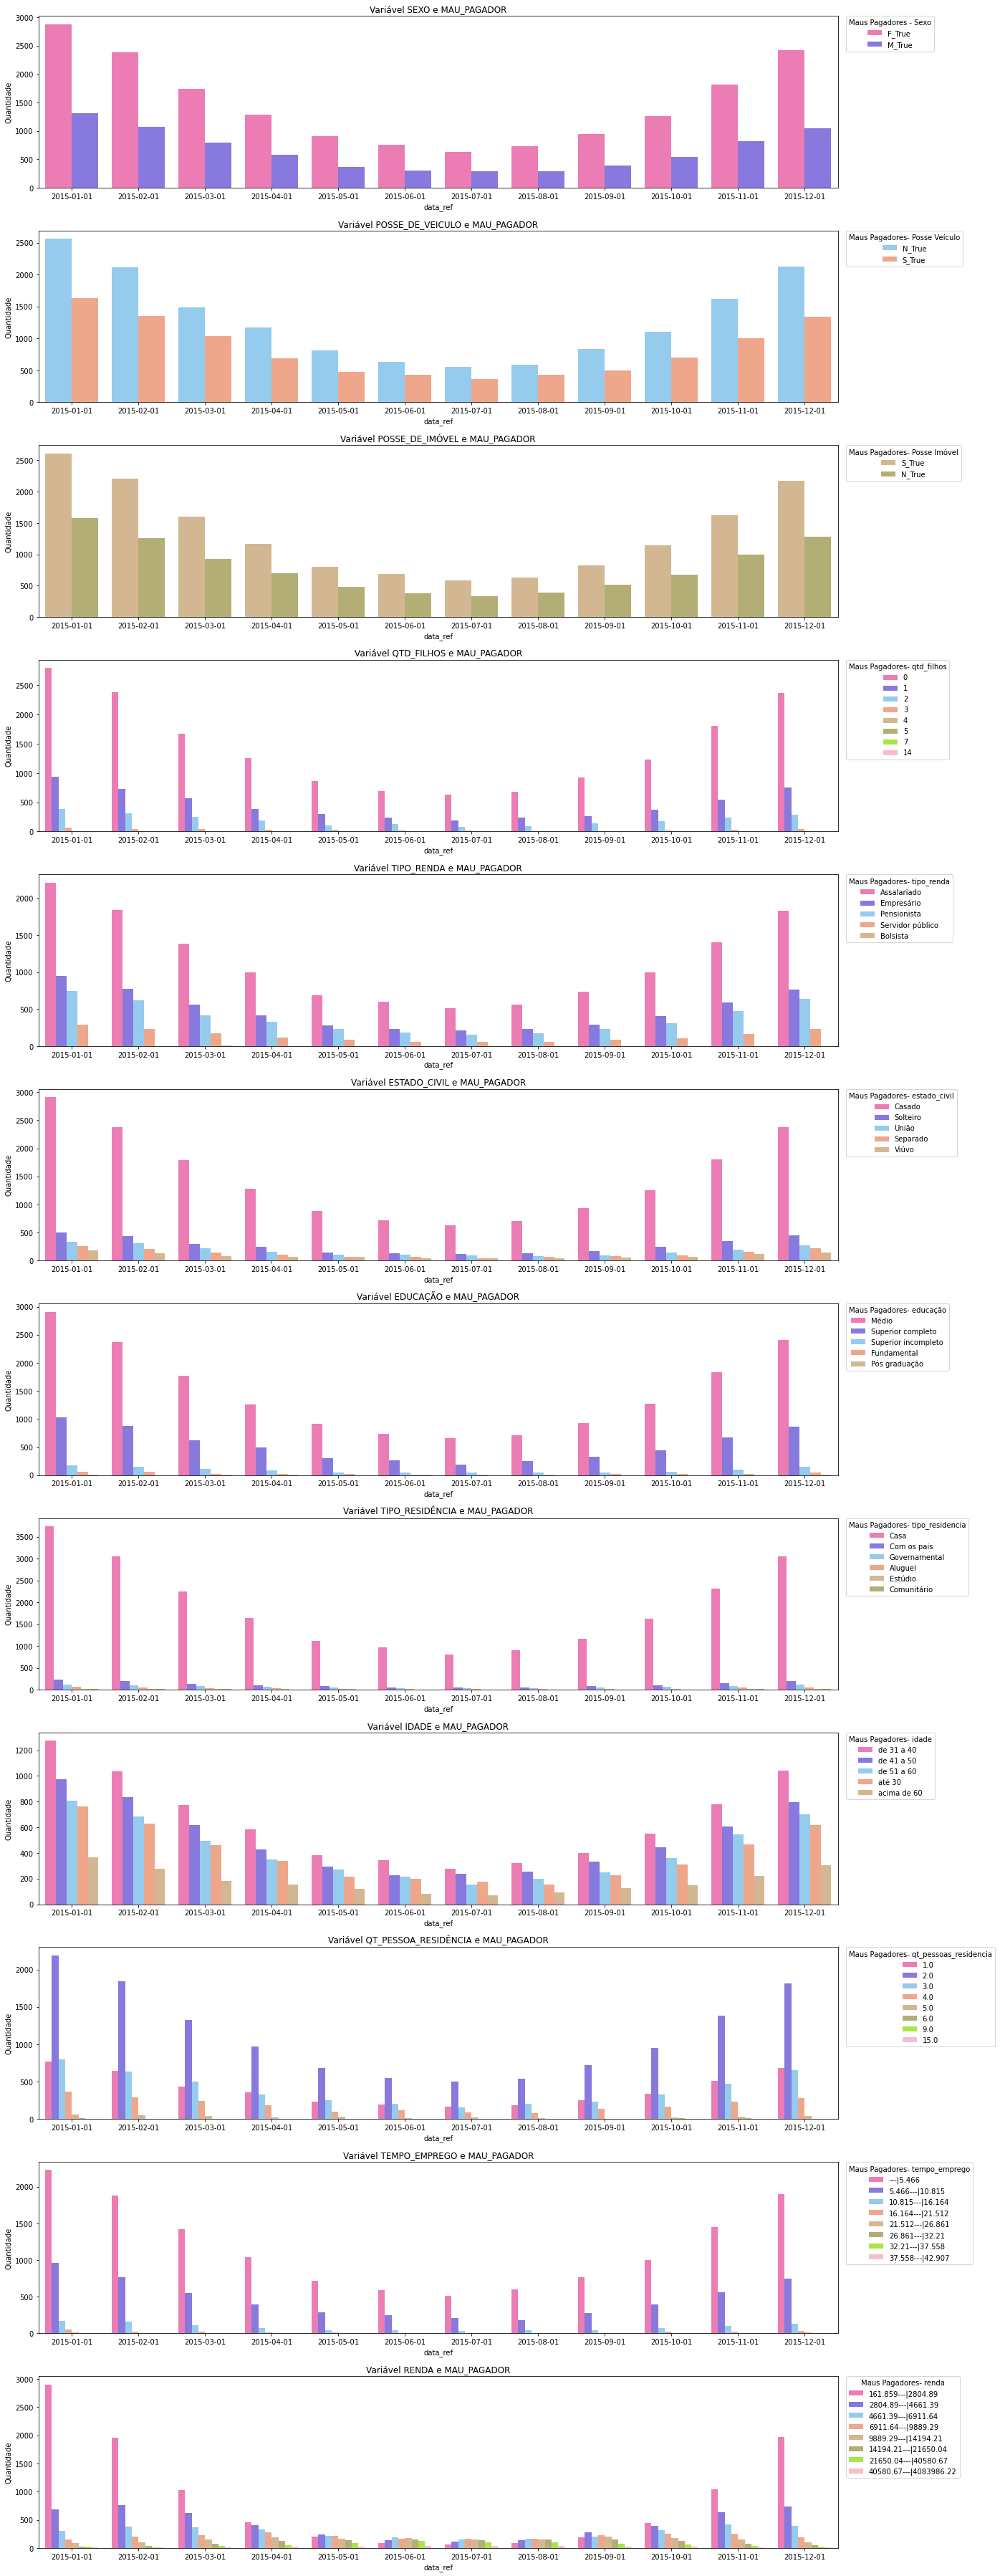

In [16]:
plt.rc('figure', figsize=(20,65))
fig, axes = plt.subplots(12)

ax = axes[0]
var = ['sexo', 'mau']
dt1 = pd.DataFrame(df_train.groupby('data_ref')[var].value_counts()).stack().reset_index()
dt1['sexo-mau'] = dt1['sexo']+'_'+dt1['mau'].astype(str)
dt1 = dt1.loc[dt1['mau']==True]
colors = ['hotpink', 'mediumslateblue']
sns.set_palette(sns.color_palette(colors))
sns.barplot(ax = axes[0], data = dt1, x='data_ref', y= 0, hue = 'sexo-mau')
ax.set_ylabel('Quantidade');
ax.set_title('Variável SEXO e MAU_PAGADOR')
ax.legend(bbox_to_anchor = (1.01,1), loc='upper left', borderaxespad = 0, title='Maus Pagadores - Sexo')

ax = axes[1]
var = ['posse_de_veiculo', 'mau']
dt1 = pd.DataFrame(df_train.groupby('data_ref')[var].value_counts()).stack().reset_index()
dt1['veiculo-mau'] = dt1['posse_de_veiculo']+'_'+dt1['mau'].astype(str)
dt1 = dt1.loc[dt1['mau']==True]
colors = ['lightskyblue', 'lightsalmon']
sns.set_palette(sns.color_palette(colors))
sns.barplot(ax = axes[1], data = dt1, x='data_ref', y= 0, hue = 'veiculo-mau')
ax.set_ylabel('Quantidade');
ax.set_title('Variável POSSE_DE_VEICULO e MAU_PAGADOR')
ax.legend(bbox_to_anchor = (1.01,1), loc='upper left', borderaxespad = 0, title='Maus Pagadores- Posse Veículo')

ax = axes[2]
var = ['posse_de_imovel', 'mau']
dt1 = pd.DataFrame(df_train.groupby('data_ref')[var].value_counts()).stack().reset_index()
dt1['imovel-mau'] = dt1['posse_de_imovel']+'_'+dt1['mau'].astype(str)
dt1 = dt1.loc[dt1['mau']==True]
colors = ['burlywood', 'darkkhaki']
sns.set_palette(sns.color_palette(colors))
sns.barplot(ax = axes[2], data = dt1, x='data_ref', y= 0, hue = 'imovel-mau')
ax.set_ylabel('Quantidade');
ax.set_title('Variável POSSE_DE_IMÓVEL e MAU_PAGADOR')
ax.legend(bbox_to_anchor = (1.01,1), loc='upper left', borderaxespad = 0, title='Maus Pagadores- Posse Imóvel')

ax = axes[3]
var = ['qtd_filhos', 'mau']
dt1 = pd.DataFrame(df_train.groupby('data_ref')[var].value_counts()).stack().reset_index()
dt1 = dt1.loc[dt1['mau']==True]
colors = ['hotpink', 'mediumslateblue', 'lightskyblue', 'lightsalmon', 'burlywood', 'darkkhaki', 'greenyellow', 'lightpink']
sns.set_palette(sns.color_palette(colors))
sns.barplot(ax = axes[3], data = dt1, x='data_ref', y= 0, hue = 'qtd_filhos')
ax.set_ylabel('Quantidade');
ax.set_title('Variável QTD_FILHOS e MAU_PAGADOR')
ax.legend(bbox_to_anchor = (1.01,1), loc='upper left', borderaxespad = 0,title='Maus Pagadores- qtd_filhos' )

ax = axes[4]
var = ['tipo_renda', 'mau']
dt1 = pd.DataFrame(df_train.groupby('data_ref')[var].value_counts()).stack().reset_index()
dt1 = dt1.loc[dt1['mau']==True]
colors = ['hotpink', 'mediumslateblue', 'lightskyblue', 'lightsalmon', 'burlywood', 'darkkhaki', 'greenyellow', 'lightpink']
sns.set_palette(sns.color_palette(colors))
sns.barplot(ax = axes[4], data = dt1, x='data_ref', y= 0, hue = 'tipo_renda')
ax.set_ylabel('Quantidade');
ax.set_title('Variável TIPO_RENDA e MAU_PAGADOR')
ax.legend(bbox_to_anchor = (1.01,1), loc='upper left', borderaxespad = 0,title='Maus Pagadores- tipo_renda' )

ax = axes[5]
var = ['estado_civil', 'mau']
dt1 = pd.DataFrame(df_train.groupby('data_ref')[var].value_counts()).stack().reset_index()
dt1 = dt1.loc[dt1['mau']==True]
colors = ['hotpink', 'mediumslateblue', 'lightskyblue', 'lightsalmon', 'burlywood', 'darkkhaki', 'greenyellow', 'lightpink']
sns.set_palette(sns.color_palette(colors))
sns.barplot(ax = axes[5], data = dt1, x='data_ref', y= 0, hue = 'estado_civil')
ax.set_ylabel('Quantidade');
ax.set_title('Variável ESTADO_CIVIL e MAU_PAGADOR')
ax.legend(bbox_to_anchor = (1.01,1), loc='upper left', borderaxespad = 0,title='Maus Pagadores- estado_civil' )

ax = axes[6]
var = ['educacao', 'mau']
dt1 = pd.DataFrame(df_train.groupby('data_ref')[var].value_counts()).stack().reset_index()
dt1 = dt1.loc[dt1['mau']==True]
colors = ['hotpink', 'mediumslateblue', 'lightskyblue', 'lightsalmon', 'burlywood', 'darkkhaki', 'greenyellow', 'lightpink']
sns.set_palette(sns.color_palette(colors))
sns.barplot(ax = axes[6], data = dt1, x='data_ref', y= 0, hue = 'educacao')
ax.set_ylabel('Quantidade');
ax.set_title('Variável EDUCAÇÃO e MAU_PAGADOR')
ax.legend(bbox_to_anchor = (1.01,1), loc='upper left', borderaxespad = 0,title='Maus Pagadores- educação' )

ax = axes[7]
var = ['tipo_residencia', 'mau']
dt1 = pd.DataFrame(df_train.groupby('data_ref')[var].value_counts()).stack().reset_index()
dt1 = dt1.loc[dt1['mau']==True]
colors = ['hotpink', 'mediumslateblue', 'lightskyblue', 'lightsalmon', 'burlywood', 'darkkhaki', 'greenyellow', 'lightpink']
sns.set_palette(sns.color_palette(colors))
sns.barplot(ax = axes[7], data = dt1, x='data_ref', y= 0, hue = 'tipo_residencia')
ax.set_ylabel('Quantidade');
ax.set_title('Variável TIPO_RESIDÊNCIA e MAU_PAGADOR')
ax.legend(bbox_to_anchor = (1.01,1), loc='upper left', borderaxespad = 0,title='Maus Pagadores- tipo_residencia' )

ax = axes[8]
var = ['idade_cat', 'mau']
dt1 = pd.DataFrame(df_train.groupby('data_ref')[var].value_counts()).stack().reset_index()
dt1 = dt1.loc[dt1['mau']==True]
colors = ['hotpink', 'mediumslateblue', 'lightskyblue', 'lightsalmon', 'burlywood', 'darkkhaki', 'greenyellow', 'lightpink']
sns.set_palette(sns.color_palette(colors))
sns.barplot(ax = axes[8], data = dt1, x='data_ref', y= 0, hue = 'idade_cat')
ax.set_ylabel('Quantidade');
ax.set_title('Variável IDADE e MAU_PAGADOR')
ax.legend(bbox_to_anchor = (1.01,1), loc='upper left', borderaxespad = 0,title='Maus Pagadores- idade')

ax = axes[9]
var = ['qt_pessoas_residencia', 'mau']
dt1 = pd.DataFrame(df_train.groupby('data_ref')[var].value_counts()).stack().reset_index()
dt1 = dt1.loc[dt1['mau']==True]
colors = ['hotpink', 'mediumslateblue', 'lightskyblue', 'lightsalmon', 'burlywood', 'darkkhaki', 'greenyellow', 'lightpink']
sns.set_palette(sns.color_palette(colors))
sns.barplot(ax = axes[9], data = dt1, x='data_ref', y= 0, hue = 'qt_pessoas_residencia')
ax.set_ylabel('Quantidade');
ax.set_title('Variável QT_PESSOA_RESIDÊNCIA e MAU_PAGADOR')
ax.legend(bbox_to_anchor = (1.01,1), loc='upper left', borderaxespad = 0,title='Maus Pagadores- qt_pessoas_residencia')

ax = axes[10]
var = ['tempo_emprego_cat', 'mau']
dt1 = pd.DataFrame(df_train.groupby('data_ref')[var].value_counts()).stack().reset_index()
dt1 = dt1.loc[dt1['mau']==True]
colors = ['hotpink', 'mediumslateblue', 'lightskyblue', 'lightsalmon', 'burlywood', 'darkkhaki', 'greenyellow', 'lightpink']
sns.set_palette(sns.color_palette(colors))
sns.barplot(ax = axes[10], data = dt1, x='data_ref', y= 0, hue = 'tempo_emprego_cat')
ax.set_ylabel('Quantidade');
ax.set_title('Variável TEMPO_EMPREGO e MAU_PAGADOR')
ax.legend(bbox_to_anchor = (1.01,1), loc='upper left', borderaxespad = 0,title='Maus Pagadores- tempo_emprego')

ax = axes[11]
var = ['renda_cat', 'mau']
dt1 = pd.DataFrame(df_train.groupby('data_ref')[var].value_counts()).stack().reset_index()
dt1 = dt1.loc[dt1['mau']==True]
colors = ['hotpink', 'mediumslateblue', 'lightskyblue', 'lightsalmon', 'burlywood', 'darkkhaki', 'greenyellow', 'lightpink']
sns.set_palette(sns.color_palette(colors))
sns.barplot(ax = axes[11], data = dt1, x='data_ref', y= 0, hue = 'renda_cat')
ax.set_ylabel('Quantidade');
ax.set_title('Variável RENDA e MAU_PAGADOR')
ax.legend(bbox_to_anchor = (1.01,1), loc='upper left', borderaxespad = 0,title='Maus Pagadores- renda' )

plt.subplots_adjust(hspace=0.25)
plt.show();

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [17]:
df_base_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420000 entries, 0 to 419999
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               420000 non-null  datetime64[ns]
 1   sexo                   420000 non-null  object        
 2   posse_de_veiculo       420000 non-null  object        
 3   posse_de_imovel        420000 non-null  object        
 4   qtd_filhos             420000 non-null  int64         
 5   tipo_renda             420000 non-null  object        
 6   educacao               420000 non-null  object        
 7   estado_civil           420000 non-null  object        
 8   tipo_residencia        420000 non-null  object        
 9   idade                  420000 non-null  int64         
 10  tempo_emprego          349542 non-null  float64       
 11  qt_pessoas_residencia  420000 non-null  float64       
 12  renda                  420000 non-null  floa

In [18]:
df_base_train.isna().sum()

data_ref                     0
sexo                         0
posse_de_veiculo             0
posse_de_imovel              0
qtd_filhos                   0
tipo_renda                   0
educacao                     0
estado_civil                 0
tipo_residencia              0
idade                        0
tempo_emprego            70458
qt_pessoas_residencia        0
renda                        0
mau                          0
dtype: int64

In [19]:
df_base_train = df_base_train.dropna().reset_index()
df_base_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349542 entries, 0 to 349541
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   index                  349542 non-null  int64         
 1   data_ref               349542 non-null  datetime64[ns]
 2   sexo                   349542 non-null  object        
 3   posse_de_veiculo       349542 non-null  object        
 4   posse_de_imovel        349542 non-null  object        
 5   qtd_filhos             349542 non-null  int64         
 6   tipo_renda             349542 non-null  object        
 7   educacao               349542 non-null  object        
 8   estado_civil           349542 non-null  object        
 9   tipo_residencia        349542 non-null  object        
 10  idade                  349542 non-null  int64         
 11  tempo_emprego          349542 non-null  float64       
 12  qt_pessoas_residencia  349542 non-null  floa

In [20]:
df_base_train.columns

Index(['index', 'data_ref', 'sexo', 'posse_de_veiculo', 'posse_de_imovel',
       'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil',
       'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda', 'mau'],
      dtype='object')

In [21]:
print(df_base_train.data_ref.value_counts())
print()
print(df_base_train.sexo.value_counts())
print()
print(df_base_train.posse_de_veiculo.value_counts())
print()
print(df_base_train.posse_de_imovel.value_counts())
print()
print(df_base_train.qtd_filhos.value_counts())
print()
print(df_base_train.tipo_renda.value_counts())
print()
print(df_base_train.educacao.value_counts())
print()
print(df_base_train.estado_civil.value_counts())
print()
print(df_base_train.tipo_residencia.value_counts())
print()
print(df_base_train.idade.value_counts().sort_index())
print()
print(df_base_train.qt_pessoas_residencia.value_counts())
print()
print(df_base_train.loc[df_base_train['tempo_emprego']==0])
print()
print(df_base_train.loc[df_base_train['renda']==0])
print()
print(df_base_train.mau.value_counts())

2015-03-01    29351
2015-12-01    29274
2015-08-01    29229
2015-10-01    29185
2015-04-01    29169
2015-06-01    29144
2015-09-01    29125
2015-02-01    29120
2015-11-01    29078
2015-05-01    28989
2015-01-01    28968
2015-07-01    28910
Name: data_ref, dtype: int64

F    222106
M    127436
Name: sexo, dtype: int64

N    201696
S    147846
Name: posse_de_veiculo, dtype: int64

S    227736
N    121806
Name: posse_de_imovel, dtype: int64

0     221509
1      84163
2      38279
3       4849
4        578
7         65
5         55
14        44
Name: qtd_filhos, dtype: int64

Assalariado         216261
Empresário           96619
Servidor público     36292
Bolsista               202
Pensionista            168
Name: tipo_renda, dtype: int64

Médio                  227955
Superior completo      102709
Superior incompleto     15670
Fundamental              2753
Pós graduação             455
Name: educacao, dtype: int64

Casado      249362
Solteiro     43690
União        27872
Separado     2035

In [22]:
df_base_train['cat_tempo_emprego'], quebras = pd.qcut(df_base_train.tempo_emprego, 8, duplicates='drop', 
                        retbins=True)

In [23]:
t_emp = pd.DataFrame()
t_emp['qtd_observações'] = df_base_train[['cat_tempo_emprego']].value_counts()
t_emp = t_emp.reset_index()
t_emp = t_emp.sort_values('cat_tempo_emprego')
t_emp = t_emp.set_index('cat_tempo_emprego')

t_emp1 = pd.DataFrame()
t_emp1['média_mau'] = df_base_train.groupby('cat_tempo_emprego')['mau'].mean()

t_emp2 = pd.DataFrame()
t_emp2['média_tempo_emprego'] = df_base_train.groupby('cat_tempo_emprego')['tempo_emprego'].mean()
t_emp2

t_emp3 = pd.concat([t_emp, t_emp1, t_emp2], axis=1)
t_emp3

,qtd_observações,média_mau,média_tempo_emprego
cat_tempo_emprego,,,
"(0.11699999999999999, 1.521]",43987,0.106168,0.846816
"(1.521, 3.044]",43434,0.090897,2.235676
"(3.044, 4.441]",43810,0.078589,3.772226
"(4.441, 6.047]",43813,0.069477,5.205046
"(6.047, 7.874]",43503,0.052387,6.923945
"(7.874, 10.184]",43852,0.045334,8.936988
"(10.184, 15.041]",43454,0.028904,12.380143
"(15.041, 42.907]",43689,0.010048,21.752979


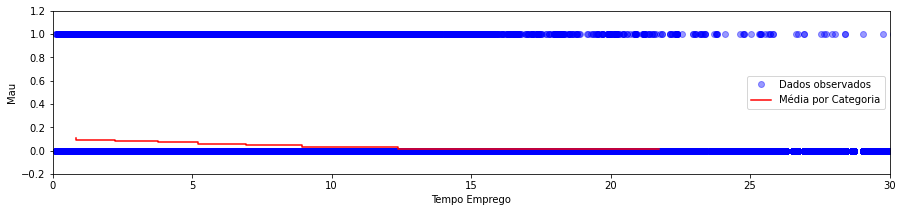

In [24]:
fig, ax = plt.subplots(figsize=(15, 3))
plt.axis([0,30, -0.2, 1.2])
ax.plot(df_base_train.tempo_emprego, df_base_train.mau, "ob", label="Dados observados", alpha=.4 )
ax.step(t_emp3.média_tempo_emprego, t_emp3.média_mau, "-r", label="Média por Categoria",
        alpha=1)
ax.set_xlabel('Tempo Emprego')
ax.set_ylabel('Mau')
ax.legend();

In [25]:
quebras

array([ 0.11780822,  1.52054795,  3.04383562,  4.44109589,  6.04657534,
        7.8739726 , 10.18356164, 15.04109589, 42.90684932])

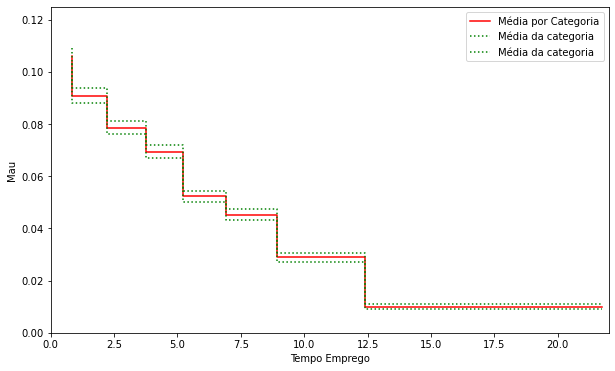

In [26]:
t_emp3['Mau_min'] = t_emp3.média_mau - 2*df_base_train.groupby('cat_tempo_emprego')['mau'].sem()
t_emp3['Mau_max'] = t_emp3.média_mau + 2*df_base_train.groupby('cat_tempo_emprego')['mau'].sem()

fig, ax = plt.subplots(figsize=(10, 6))
plt.axis([0,22, -0, 0.125])

ax.step(t_emp3.média_tempo_emprego, t_emp3.média_mau, "-r", label="Média por Categoria",
        alpha=1)
ax.step(t_emp3.média_tempo_emprego, t_emp3.Mau_min, "g:", label="Média da categoria", alpha=1)
ax.step(t_emp3.média_tempo_emprego, t_emp3.Mau_max, "g:", label="Média da categoria", alpha=1)
ax.legend()
ax.set_xlabel('Tempo Emprego')
ax.set_ylabel('Mau');

In [27]:
df_base_train['cat_renda'], quebras = pd.qcut(df_base_train.renda, 8, duplicates='drop', 
                        retbins=True)

In [28]:
renda = pd.DataFrame()
renda['qtd_observações'] = df_base_train[['cat_renda']].value_counts()
renda = renda.reset_index()
renda = renda.sort_values('cat_renda')
renda = renda.set_index('cat_renda')

renda1 = pd.DataFrame()
renda1['média_mau'] = df_base_train.groupby('cat_renda')['mau'].mean()

renda2 = pd.DataFrame()
renda2['média_renda'] = df_base_train.groupby('cat_renda')['renda'].mean()
renda2

renda3 = pd.concat([renda, renda1, renda2], axis=1)
renda3

,qtd_observações,média_mau,média_renda
cat_renda,,,
"(161.859, 2786.18]",43697,0.201089,1796.586624
"(2786.18, 4714.555]",43689,0.098583,3727.700550
"(4714.555, 7090.515]",43692,0.064382,5844.419359
"(7090.515, 10290.36]",43693,0.047239,8583.494977
"(10290.36, 15038.94]",43695,0.031834,12472.872497
"(15038.94, 23521.52]",43691,0.021652,18794.303977
"(23521.52, 45867.34]",43693,0.012931,32451.306855
"(45867.34, 4083986.22]",43692,0.004440,157965.075307


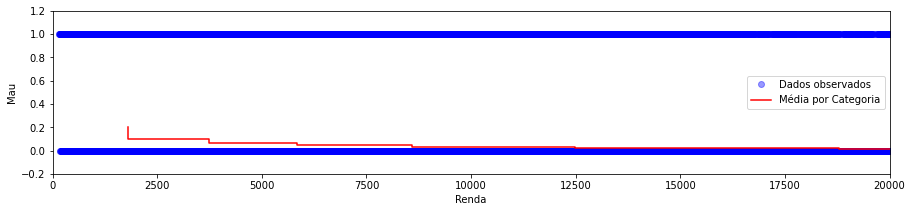

In [29]:
fig, ax = plt.subplots(figsize=(15, 3))
plt.axis([0,20000, -0.2, 1.2])
ax.plot(df_base_train.renda, df_base_train.mau, "ob", label="Dados observados", alpha=.4 )
ax.step(renda3.média_renda, renda3.média_mau, "-r", label="Média por Categoria",
        alpha=1)
ax.set_xlabel('Renda')
ax.set_ylabel('Mau')
ax.legend();

In [30]:
quebras

array([1.61860000e+02, 2.78618000e+03, 4.71455500e+03, 7.09051500e+03,
       1.02903600e+04, 1.50389400e+04, 2.35215200e+04, 4.58673400e+04,
       4.08398622e+06])

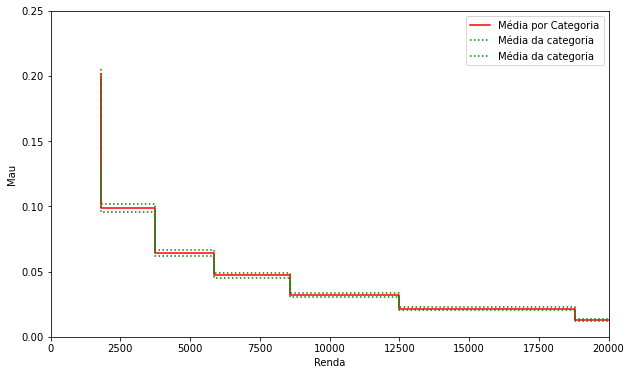

In [31]:
renda3['Mau_min'] = renda3.média_mau - 2*df_base_train.groupby('cat_renda')['mau'].sem()
renda3['Mau_max'] = renda3.média_mau + 2*df_base_train.groupby('cat_renda')['mau'].sem()

fig, ax = plt.subplots(figsize=(10, 6))
plt.axis([0,20000, -0, 0.25])

ax.step(renda3.média_renda, renda3.média_mau, "-r", label="Média por Categoria",
        alpha=1)
ax.step(renda3.média_renda, renda3.Mau_min, "g:", label="Média da categoria", alpha=1)
ax.step(renda3.média_renda, renda3.Mau_max, "g:", label="Média da categoria", alpha=1)
ax.legend()
ax.set_xlabel('Renda')
ax.set_ylabel('Mau');

In [32]:
df_base_train.dtypes

index                             int64
data_ref                 datetime64[ns]
sexo                             object
posse_de_veiculo                 object
posse_de_imovel                  object
qtd_filhos                        int64
tipo_renda                       object
educacao                         object
estado_civil                     object
tipo_residencia                  object
idade                             int64
tempo_emprego                   float64
qt_pessoas_residencia           float64
renda                           float64
mau                                bool
cat_tempo_emprego              category
cat_renda                      category
dtype: object

In [33]:
df_base_train['mau'] = df_base_train.mau.astype('int64')

In [34]:
df_base_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349542 entries, 0 to 349541
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   index                  349542 non-null  int64         
 1   data_ref               349542 non-null  datetime64[ns]
 2   sexo                   349542 non-null  object        
 3   posse_de_veiculo       349542 non-null  object        
 4   posse_de_imovel        349542 non-null  object        
 5   qtd_filhos             349542 non-null  int64         
 6   tipo_renda             349542 non-null  object        
 7   educacao               349542 non-null  object        
 8   estado_civil           349542 non-null  object        
 9   tipo_residencia        349542 non-null  object        
 10  idade                  349542 non-null  int64         
 11  tempo_emprego          349542 non-null  float64       
 12  qt_pessoas_residencia  349542 non-null  floa

In [35]:
formula = '''mau ~ posse_de_veiculo + posse_de_imovel + qtd_filhos + idade + cat_tempo_emprego+
       qt_pessoas_residencia + C(sexo) + C(tipo_renda) + C(educacao) + C(estado_civil)+
        C(tipo_residencia) + cat_renda'''

rl = smf.glm(formula, data=df_base_train, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               349542
Model:                            GLM   Df Residuals:                   349504
Model Family:                Binomial   Df Model:                           37
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -69702.
Date:                Tue, 28 Feb 2023   Deviance:                   1.3940e+05
Time:                        14:33:25   Pearson chi2:                 3.49e+05
No. Iterations:                     8   Pseudo R-squ. (CS):            0.05503
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        -1.3379      0.274     -4.891      0.000      -1.874      -0.802
posse_de_veiculo[T.S]                                             0.0442      0.016      2.739      0.006       0.013       0.076
posse_de_imovel[T.S]                                             -0.0452      0.016     -2.888      0.004      -0.076      -0.015
cat_tempo_emprego[T.Interval(1.521, 3.044, closed='right')]      -0.0541      0.024     -2.298      0.022      -0.100      -0.008
cat_tempo_emprego[T.Interval(3.044, 4.441, closed='right')]      -0.0431      0.024     -1.765      0.078      -0.091       0.005
cat_tempo_emprego[T.Interval(4.441, 6.047, closed='right')]      -0.0305      0.025     -1.199      0.231      -0.080       0.019
cat_tempo_emprego[T.Interval(6.047, 7.874, closed='right')]      -0.1126      0.028     -4.034      0.000      -0.167      -0.058
cat_tempo_emprego[T.Interval(7.874, 10.184, closed='right')]     -0.0819      0.029     -2.790      0.005      -0.139      -0.024
cat_tempo_emprego[T.Interval(10.184, 15.041, closed='right')]    -0.0713      0.036     -2.004      0.045      -0.141      -0.002
cat_tempo_emprego[T.Interval(15.041, 42.907, closed='right')]    -0.2294      0.058     -3.954      0.000      -0.343      -0.116
C(sexo)[T.M]                                                     -0.0629      0.017     -3.740      0.000      -0.096      -0.030
C(tipo_renda)[T.Bolsista]                                         0.2547      0.350      0.728      0.467      -0.431       0.941
C(tipo_renda)[T.Empresário]                                      -0.0360      0.017     -2.109      0.035      -0.069      -0.003
C(tipo_renda)[T.Pensionista]                                     -0.2174      0.297     -0.733      0.464      -0.799       0.364
C(tipo_renda)[T.Servidor público]                                -0.0056      0.028     -0.201      0.841      -0.061       0.049
C(educacao)[T.Médio]                                              0.0043      0.078      0.055      0.956      -0.148       0.156
C(educacao)[T.Pós graduação]                                     -0.0789      0.219     -0.360      0.719      -0.508       0.350
C(educacao)[T.Superior completo]                                 -0.0244      0.078     -0.311      0.756      -0.178       0.129
C(educacao)[T.Superior incompleto]                                0.0170      0.084      0.202      0.840      -0.148       0.182
C(estado_civil)[T.Separado]                                       0.0231      0.131      0.177      0.860      -0.233       0.279
C(estado_civil)[T.Solteiro]                                       0.0229      0.128      0.17

In [36]:
df_base_train = df_base_train.drop(['index', 'data_ref'], axis=1)

In [37]:
metadados = pd.DataFrame(df_base_train.dtypes, columns=['dtype'])
metadados['n_missings'] = df_base_train.isna().sum()
metadados['valores_únicos'] = df_base_train.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau', 'papel'] = 'resposta'
metadados = metadados.T
metadados = metadados[['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos',
       'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'idade',
       'tempo_emprego', 'qt_pessoas_residencia', 'renda', 
       'cat_tempo_emprego', 'cat_renda', 'mau']]
metadados = metadados.T
metadados.loc['bom', 'papel'] = 'resposta'
metadados

,dtype,n_missings,valores_únicos,papel
sexo,object,0,2,covariavel
posse_de_veiculo,object,0,2,covariavel
posse_de_imovel,object,0,2,covariavel
qtd_filhos,int64,0,8,covariavel
tipo_renda,object,0,5,covariavel
educacao,object,0,5,covariavel
estado_civil,object,0,5,covariavel
tipo_residencia,object,0,6,covariavel
idade,int64,0,46,covariavel
tempo_emprego,float64,0,3004,covariavel


In [38]:
def IV(variavel, resposta):
    
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')
    
    rótulo_não_evento = tab.columns[0]
    rótulo_evento = tab.columns[1] #como o objetivo é predizer os maus pagadores, o rótulo de evento é a coluna 1
    
    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total', rótulo_evento]
    tab['pct_não_evento'] = tab[rótulo_não_evento]/tab.loc['total', rótulo_não_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_não_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_não_evento)*tab.woe
    return tab['iv_parcial'].sum()    

In [39]:
for var in metadados[metadados.papel=='covariavel'].index:
    if (metadados.loc[var, 'valores_únicos']>46):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df_base_train[var], 5, duplicates='drop'), df_base_train.mau)
    else:
        metadados.loc[var, 'IV'] = IV(df_base_train[var], df_base_train.mau)

metadados

/opt/anaconda/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,dtype,n_missings,valores_únicos,papel,IV
sexo,object,0,2,covariavel,0.002336
posse_de_veiculo,object,0,2,covariavel,0.000004
posse_de_imovel,object,0,2,covariavel,0.011140
qtd_filhos,int64,0,8,covariavel,0.002347
tipo_renda,object,0,5,covariavel,0.010793
educacao,object,0,5,covariavel,0.003783
estado_civil,object,0,5,covariavel,0.002240
tipo_residencia,object,0,6,covariavel,0.004383
idade,int64,0,46,covariavel,inf
tempo_emprego,float64,0,3004,covariavel,0.352113


In [40]:
metadados.loc[metadados['IV']<=0.02, 'Poder_Preditivo(Siddiqi)'] = 'inútil'
metadados.loc[(metadados['IV']>0.02) & (metadados['IV']<=0.1), 'Poder_Preditivo(Siddiqi)'] = 'fraco'
metadados.loc[(metadados['IV']>0.1) & (metadados['IV']<=0.3), 'Poder_Preditivo(Siddiqi)'] = 'médio'
metadados.loc[(metadados['IV']>0.3) & (metadados['IV']<=0.5), 'Poder_Preditivo(Siddiqi)'] = 'forte'
metadados.loc[(metadados['IV']>0.5), 'Poder_Preditivo(Siddiqi)'] = 'Muito Alto - análise'
metadados

,dtype,n_missings,valores_únicos,papel,IV,Poder_Preditivo(Siddiqi)
sexo,object,0,2,covariavel,0.002336,inútil
posse_de_veiculo,object,0,2,covariavel,0.000004,inútil
posse_de_imovel,object,0,2,covariavel,0.011140,inútil
qtd_filhos,int64,0,8,covariavel,0.002347,inútil
tipo_renda,object,0,5,covariavel,0.010793,inútil
educacao,object,0,5,covariavel,0.003783,inútil
estado_civil,object,0,5,covariavel,0.002240,inútil
tipo_residencia,object,0,6,covariavel,0.004383,inútil
idade,int64,0,46,covariavel,inf,Muito Alto - análise
tempo_emprego,float64,0,3004,covariavel,0.352113,forte


In [41]:
def biv_discreta(var, df):
    
    df['bom'] = 1 - df.mau
    g=df.groupby(var)
    
    biv = pd.DataFrame({'qt_bom': g['bom'].sum(), 'qt_mau':g['mau'].sum(), 
                       'mau':g['mau'].mean(), var:g['mau'].mean().index, 
                       'cont': g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))
    
    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean()/(1-df.mau.mean()))
    
    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral
    
    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label = 'woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label = 'limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label = 'limite inferior')
    
    num_cat = biv.shape[0]
        
    ax[0].set_ylabel('Weight of Evidence')
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    
    ax[1]=biv.cont.plot.bar()
    return biv
    
    

,qt_bom,qt_mau,mau,sexo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
sexo,,,,,,,,,,,,,,
F,208262,13844,0.062331,F,222106,0.000513,0.063336,0.061325,-2.710945,-2.693870,-2.728279,0.035808,0.052882,0.018474
M,120213,7223,0.056679,M,127436,0.000648,0.057949,0.055410,-2.811995,-2.788497,-2.835993,-0.065242,-0.041744,-0.089240


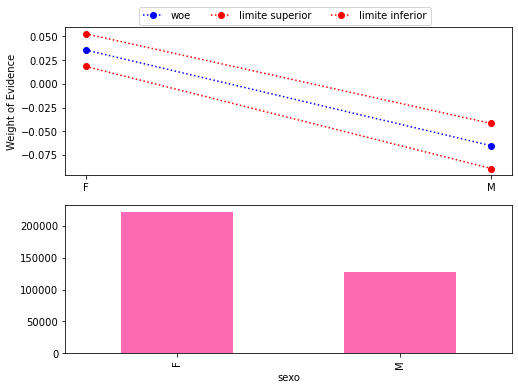

In [42]:
biv_discreta('sexo', df_base_train)

,qt_bom,qt_mau,mau,posse_de_veiculo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_veiculo,,,,,,,,,,,,,,
N,189559,12137,0.060175,N,201696,0.00053,0.061213,0.059137,-2.748442,-2.730237,-2.766943,-0.001689,0.016516,-0.020190
S,138916,8930,0.060401,S,147846,0.00062,0.061615,0.059186,-2.744453,-2.723255,-2.766054,0.002300,0.023498,-0.019301


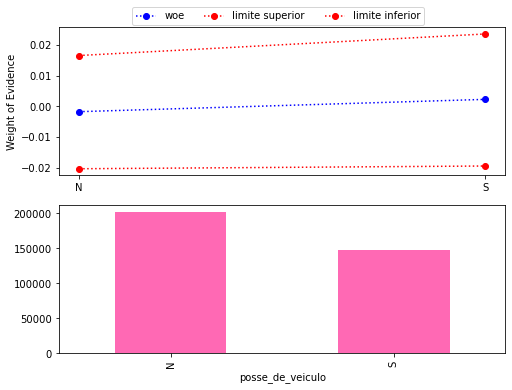

In [43]:
biv_discreta('posse_de_veiculo', df_base_train)



<font color='blue'>Note-se que a variável <font color='magenta'>'posse_de_veículo'</font> tem um WOE muito próximo do zero, o que demonstra que esta variável não possui muita relevância na classificação binária. </font>

,qt_bom,qt_mau,mau,posse_de_imovel,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_imovel,,,,,,,,,,,,,,
N,113456,8350,0.068552,N,121806,0.000724,0.069971,0.067133,-2.609154,-2.587139,-2.631594,0.137599,0.159614,0.115159
S,215019,12717,0.055841,S,227736,0.000481,0.056784,0.054898,-2.827787,-2.810040,-2.845817,-0.081034,-0.063287,-0.099064


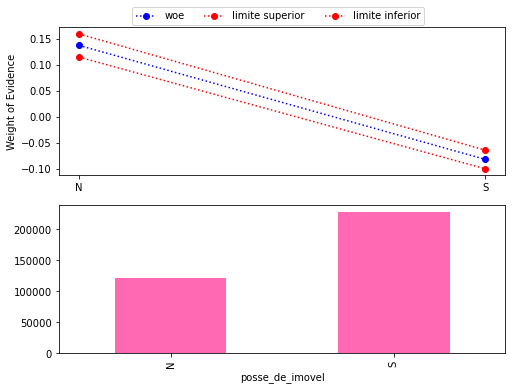

In [44]:
biv_discreta('posse_de_imovel', df_base_train)

,qt_bom,qt_mau,mau,qtd_filhos,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
qtd_filhos,,,,,,,,,,,,,,
0,208516,12993,0.058657,0,221509,0.000499,0.059635,0.057678,-2.775605,-2.758020,-2.793468,-0.028852,-0.011267,-0.046715
1,78792,5371,0.063817,1,84163,0.000843,0.065468,0.062165,-2.685797,-2.658484,-2.713777,0.060956,0.088268,0.032976
2,35946,2333,0.060947,2,38279,0.001223,0.063344,0.058551,-2.734863,-2.693738,-2.777529,0.011890,0.053015,-0.030776
3,4532,317,0.065374,3,4849,0.003550,0.072333,0.058415,-2.660017,-2.551386,-2.779988,0.086736,0.195366,-0.033235
4,548,30,0.051903,4,578,0.009227,0.070026,0.033781,-2.905078,-2.586295,-3.353505,-0.158325,0.160458,-0.606752
5,50,5,0.090909,5,55,0.038764,0.168626,0.013192,-2.302585,-1.595398,-4.314833,0.444168,1.151355,-1.568080
7,52,13,0.200000,7,65,0.049614,0.299115,0.100885,-1.386294,-0.851515,-2.187431,1.360459,1.895238,0.559322
14,39,5,0.113636,14,44,0.047845,0.210125,0.017147,-2.054124,-1.324170,-4.048616,0.692629,1.422583,-1.301863


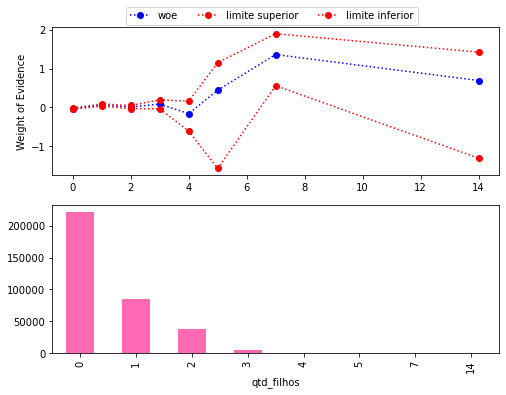

In [45]:
biv_discreta('qtd_filhos', df_base_train)

<font color=blue> Note-se que a variável <font color=magenta>qtd_filhos</font>, no intervalo compreendido de 0 a 3 filhos, apresentou WOE próximo de zero. Ao mesmo tempo este intervalo de 0 a 3 filhos compreende praticamente toda a amostra populacional.

,qt_bom,qt_mau,mau,estado_civil,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
estado_civil,,,,,,,,,,,,,,
Casado,234534,14828,0.059464,Casado,249362,0.000474,0.060392,0.058536,-2.761083,-2.744607,-2.777803,-0.014330,0.002146,-0.031050
Separado,19103,1253,0.061554,Separado,20356,0.001685,0.064856,0.058252,-2.724305,-2.668528,-2.782951,0.022448,0.078225,-0.036198
Solteiro,40909,2781,0.063653,Solteiro,43690,0.001168,0.065942,0.061364,-2.688540,-2.650758,-2.727609,0.058213,0.095994,0.019144
União,26067,1805,0.064760,União,27872,0.001474,0.067650,0.061871,-2.670110,-2.623366,-2.718836,0.076643,0.123387,0.027917
Viúvo,7862,400,0.048414,Viúvo,8262,0.002361,0.053043,0.043785,-2.978332,-2.882144,-3.083680,-0.231579,-0.135391,-0.336927


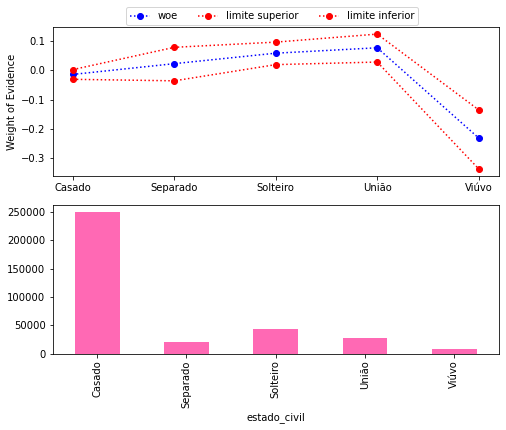

In [46]:
biv_discreta('estado_civil', df_base_train)

,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,202528,13733,0.063502,Assalariado,216261,0.000524,0.064530,0.062474,-2.691076,-2.673923,-2.708491,0.055676,0.072830,0.038262
Bolsista,193,9,0.044554,Bolsista,202,0.014517,0.073179,0.015930,-3.065466,-2.538847,-4.123520,-0.318713,0.207906,-1.376767
Empresário,90943,5676,0.058746,Empresário,96619,0.000757,0.060229,0.057263,-2.773986,-2.747483,-2.801124,-0.027233,-0.000730,-0.054371
Pensionista,155,13,0.077381,Pensionista,168,0.020615,0.118080,0.036682,-2.478476,-2.010742,-3.268090,0.268277,0.736010,-0.521337
Servidor público,34656,1636,0.045079,Servidor público,36292,0.001089,0.047213,0.042944,-3.053217,-3.004712,-3.103961,-0.306464,-0.257959,-0.357208


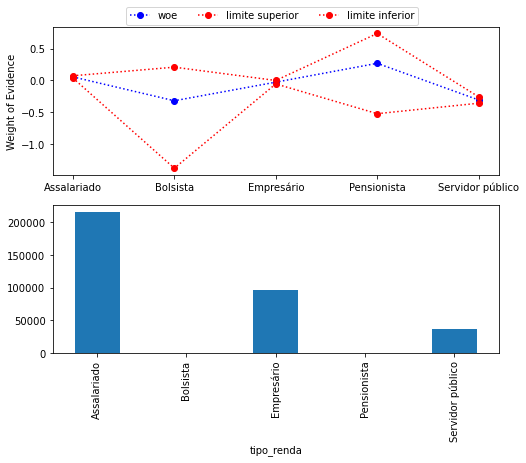

In [45]:
biv_discreta('tipo_renda', df_base_train)

,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental,2556,197,0.071558,Fundamental,2753,0.004913,0.081191,0.061926,-2.562995,-2.426275,-2.717894,0.183758,0.320478,0.028859
Médio,213834,14121,0.061946,Médio,227955,0.000505,0.062936,0.060957,-2.717537,-2.700633,-2.734695,0.029216,0.046120,0.012058
Pós graduação,428,27,0.059341,Pós graduação,455,0.011076,0.081107,0.037574,-2.763286,-2.427395,-3.243148,-0.016533,0.319358,-0.496395
Superior completo,97032,5677,0.055273,Superior completo,102709,0.000713,0.056670,0.053875,-2.838618,-2.812168,-2.865705,-0.091865,-0.065415,-0.118952
Superior incompleto,14625,1045,0.066688,Superior incompleto,15670,0.001993,0.070594,0.062781,-2.638716,-2.577594,-2.703256,0.108037,0.169159,0.043496


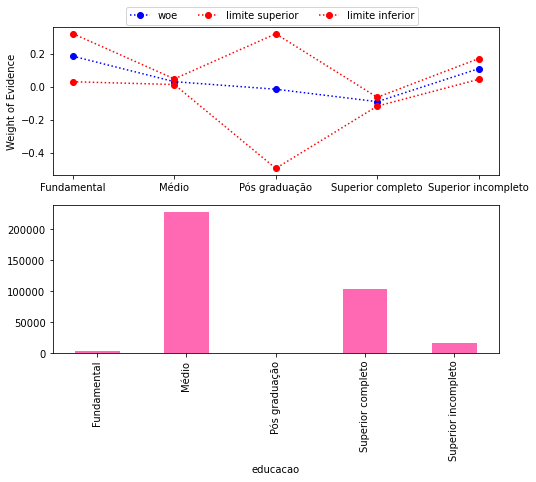

In [47]:
biv_discreta('educacao', df_base_train)

,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental/Médio,216390,14318,0.062061,Fundamental/Médio,230708,0.000502,0.063046,0.061077,-2.715565,-2.698776,-2.732605,0.031188,0.047977,0.014148
Superior completo/ Pós Graduação,97460,5704,0.055291,Superior completo/ Pós Graduação,103164,0.000712,0.056685,0.053896,-2.838274,-2.811886,-2.865297,-0.091521,-0.065133,-0.118544
Superior incompleto,14625,1045,0.066688,Superior incompleto,15670,0.001993,0.070594,0.062781,-2.638716,-2.577594,-2.703256,0.108037,0.169159,0.043496


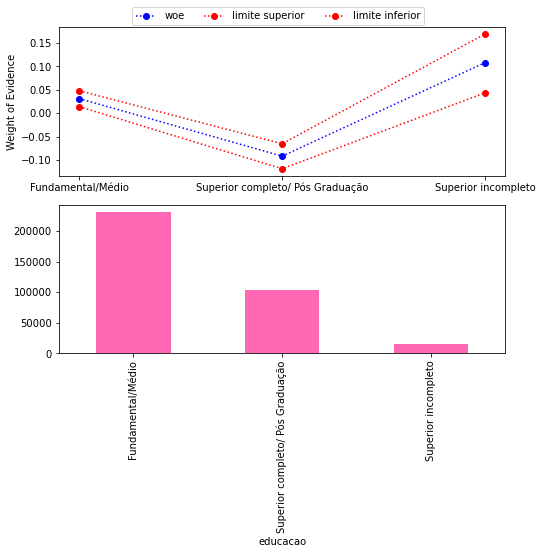

In [48]:
df2 = df_base_train.copy()
df2.educacao.replace({'Fundamental':'Fundamental/Médio', 'Médio':'Fundamental/Médio', 
                      'Superior completo': 'Superior completo/ Pós Graduação',
                      'Pós graduação': 'Superior completo/ Pós Graduação'}, inplace = True)
biv_discreta('educacao', df2)

,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,202528,13733,0.063502,Assalariado,216261,0.000524,0.064530,0.062474,-2.691076,-2.673923,-2.708491,0.055676,0.072830,0.038262
Bolsista/Pensionista,348,22,0.059459,Bolsista/Pensionista,370,0.012294,0.083635,0.035284,-2.761160,-2.393955,-3.308402,-0.014407,0.352798,-0.561649
Empresário,90943,5676,0.058746,Empresário,96619,0.000757,0.060229,0.057263,-2.773986,-2.747483,-2.801124,-0.027233,-0.000730,-0.054371
Servidor público,34656,1636,0.045079,Servidor público,36292,0.001089,0.047213,0.042944,-3.053217,-3.004712,-3.103961,-0.306464,-0.257959,-0.357208


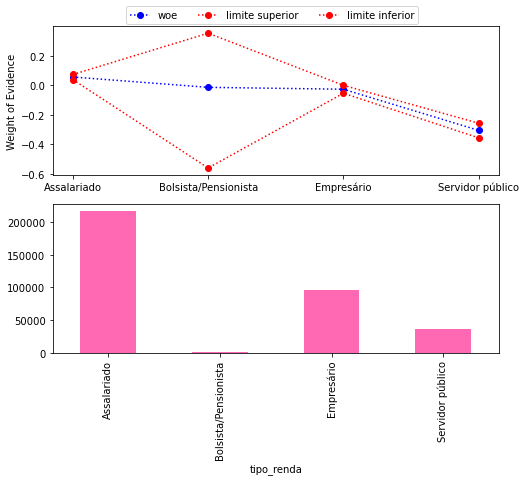

In [49]:
df2.tipo_renda.replace({'Bolsista':'Bolsista/Pensionista', 'Pensionista':'Bolsista/Pensionista'},
                       inplace = True)
biv_discreta('tipo_renda', df2)

In [50]:
def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[1] = biv.cont.plot.bar()
    return None

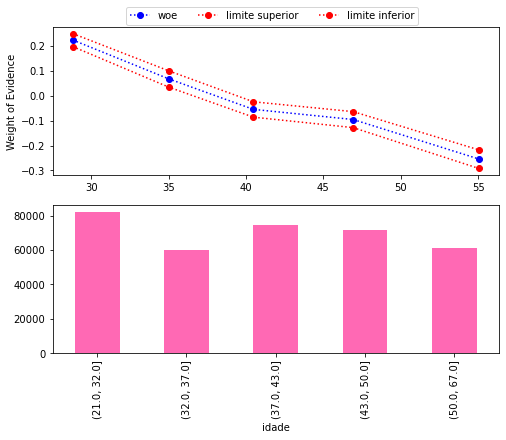

In [51]:
biv_continua('idade', 5, df2)

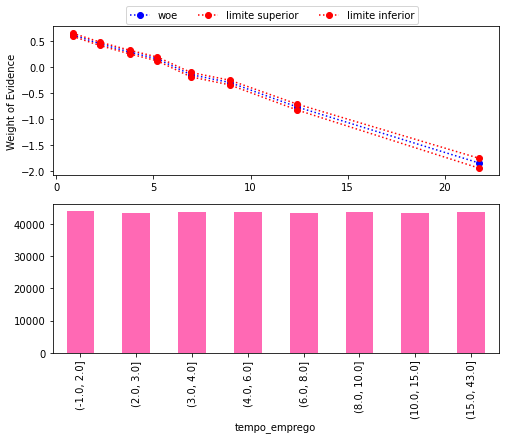

In [52]:
biv_continua('tempo_emprego',8, df2)

In [53]:
df_base_train.columns
df_base_train.tempo_emprego.describe()

count    349542.000000
mean          7.750465
std           6.693791
min           0.117808
25%           3.043836
50%           6.046575
75%          10.183562
max          42.906849
Name: tempo_emprego, dtype: float64

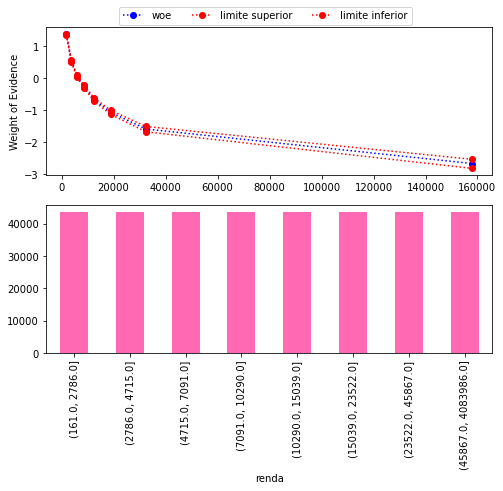

In [54]:
biv_continua('renda', 8, df2)

In [55]:
metadados2 = pd.DataFrame(df2.dtypes, columns=['dtype'])
metadados2['n_missings'] = df2.isna().sum()
metadados2['valores_únicos'] = df2.nunique()
metadados2['papel'] = 'covariavel'
metadados2.loc['mau', 'papel'] = 'resposta'
metadados2.loc['bom', 'papel'] = 'resposta'

for var in metadados2[metadados2.papel=='covariavel'].index:
    if (metadados2.loc[var, 'valores_únicos']>46):
        metadados2.loc[var, 'IV'] = IV(pd.qcut(df2[var], 5, duplicates='drop'), df2.mau)
    else:
        metadados2.loc[var, 'IV'] = IV(df2[var], df2.mau)


/opt/anaconda/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [56]:
metadados2.loc[metadados2['IV']<=0.02, 'Poder_Preditivo(Siddiqi)'] = 'inútil'
metadados2.loc[(metadados2['IV']>0.02) & (metadados2['IV']<=0.1), 'Poder_Preditivo(Siddiqi)'] = 'fraco'
metadados2.loc[(metadados2['IV']>0.1) & (metadados2['IV']<=0.3), 'Poder_Preditivo(Siddiqi)'] = 'médio'
metadados2.loc[(metadados2['IV']>0.3) & (metadados2['IV']<=0.5), 'Poder_Preditivo(Siddiqi)'] = 'forte'
metadados2.loc[(metadados2['IV']>0.5), 'Poder_Preditivo(Siddiqi)'] = 'Muito Alto - análise'

metadados2.sort_values(by='IV', ascending=False)

,dtype,n_missings,valores_únicos,papel,IV,Poder_Preditivo(Siddiqi)
idade,int64,0,46,covariavel,inf,Muito Alto - análise
qt_pessoas_residencia,float64,0,9,covariavel,inf,Muito Alto - análise
cat_renda,category,0,8,covariavel,1.105170,Muito Alto - análise
renda,float64,0,91108,covariavel,1.025739,Muito Alto - análise
cat_tempo_emprego,category,0,8,covariavel,0.377019,forte
tempo_emprego,float64,0,3004,covariavel,0.352113,forte
posse_de_imovel,object,0,2,covariavel,0.011140,inútil
tipo_renda,object,0,4,covariavel,0.010703,inútil
tipo_residencia,object,0,6,covariavel,0.004383,inútil
educacao,object,0,3,covariavel,0.003575,inútil


<font color=blue>Analisando o WOE e o IV de cada variável, exclui-se a variável <font color=magenta>posse_de_veículo</font> e <font color=magenta>qtd_filhos</font>por ser muito insignificante tanto para o IV e para o WOE. As vaiáveis <font color=magenta>idade </font>e<font color=magenta> qt_pessoas_residência </font> foram também excluídas por apresentar IV infinito. Assim de um total de 12 variáveis explicativas, reduziu-se para 7 variáveis</font>

In [57]:
formula = '''mau ~ estado_civil + sexo + educacao + tipo_renda + posse_de_imovel
            + cat_tempo_emprego + cat_renda'''

rl = smf.glm(formula, data=df2, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               349542
Model:                            GLM   Df Residuals:                   349516
Model Family:                Binomial   Df Model:                           25
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -69710.
Date:                Tue, 28 Feb 2023   Deviance:                   1.3942e+05
Time:                        14:35:49   Pearson chi2:                 3.49e+05
No. Iterations:                     8   Pseudo R-squ. (CS):            0.05499
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        -1.2880      0.022    -57.794      0.000      -1.332      -1.244
estado_civil[T.Separado]                                         -0.0058      0.032     -0.183      0.855      -0.068       0.056
estado_civil[T.Solteiro]                                         -0.0045      0.022     -0.203      0.839      -0.048       0.039
estado_civil[T.União]                                             0.0198      0.027      0.739      0.460      -0.033       0.072
estado_civil[T.Viúvo]                                            -0.1158      0.054     -2.142      0.032      -0.222      -0.010
sexo[T.M]                                                        -0.0480      0.016     -3.042      0.002      -0.079      -0.017
educacao[T.Superior completo/ Pós Graduação]                     -0.0263      0.017     -1.553      0.121      -0.059       0.007
educacao[T.Superior incompleto]                                   0.0113      0.034      0.329      0.742      -0.056       0.079
tipo_renda[T.Bolsista/Pensionista]                               -0.0367      0.228     -0.161      0.872      -0.483       0.409
tipo_renda[T.Empresário]                                         -0.0338      0.017     -1.983      0.047      -0.067      -0.000
tipo_renda[T.Servidor público]                                   -0.0054      0.028     -0.193      0.847      -0.060       0.050
posse_de_imovel[T.S]                                             -0.0453      0.015     -2.981      0.003      -0.075      -0.016
cat_tempo_emprego[T.Interval(1.521, 3.044, closed='right')]      -0.0481      0.023     -2.047      0.041      -0.094      -0.002
cat_tempo_emprego[T.Interval(3.044, 4.441, closed='right')]      -0.0388      0.024     -1.594      0.111      -0.087       0.009
cat_tempo_emprego[T.Interval(4.441, 6.047, closed='right')]      -0.0250      0.025     -0.988      0.323      -0.075       0.025
cat_tempo_emprego[T.Interval(6.047, 7.874, closed='right')]      -0.1074      0.028     -3.859      0.000      -0.162      -0.053
cat_tempo_emprego[T.Interval(7.874, 10.184, closed='right')]     -0.0775      0.029     -2.644      0.008      -0.135      -0.020
cat_tempo_emprego[T.Interval(10.184, 15.041, closed='right')]    -0.0618      0.035     -1.751      0.080      -0.131       0.007
cat_tempo_emprego[T.Interval(15.041, 42.907, closed='right')]    -0.2226      0.058     -3.853      0.000      -0.336      -0.109
cat_renda[T.Interval(2786.18, 4714.555, closed='right')]         -0.8178      0.020    -40.407      0.000      -0.857      -0.778
cat_renda[T.Interval(4714.555, 7090.515, closed='right')]        -1.2728      0.023    -54.49

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [59]:
df2['score'] = rl.predict(df2)

# Acurácia
acc = metrics.accuracy_score(df2.mau, df2.score>.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df2.mau, df2.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df2.loc[df2.mau == 1, 'score'], df2.loc[df2.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia: 75.0% 
AUC: 77.0% 
GINI: 54.1%
KS: 40.5%


In [62]:
df_base_test['mau'] = df_base_test.mau.astype('int64')

In [75]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180000 entries, 0 to 179999
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               180000 non-null  datetime64[ns]
 1   sexo                   180000 non-null  object        
 2   posse_de_veiculo       180000 non-null  object        
 3   posse_de_imovel        180000 non-null  object        
 4   qtd_filhos             180000 non-null  int64         
 5   tipo_renda             180000 non-null  object        
 6   educacao               180000 non-null  object        
 7   estado_civil           180000 non-null  object        
 8   tipo_residencia        180000 non-null  object        
 9   idade                  180000 non-null  int64         
 10  tempo_emprego          149790 non-null  float64       
 11  qt_pessoas_residencia  180000 non-null  float64       
 12  renda                  180000 non-null  floa

In [64]:
df3 = df_base_test.copy()
df3.educacao.replace({'Fundamental':'Fundamental/Médio', 'Médio':'Fundamental/Médio', 
                      'Superior completo': 'Superior completo/ Pós Graduação',
                      'Pós graduação': 'Superior completo/ Pós Graduação'}, inplace = True)
df3.tipo_renda.replace({'Bolsista':'Bolsista/Pensionista', 'Pensionista':'Bolsista/Pensionista'},
                       inplace = True)

In [66]:
df3['cat_tempo_emprego'], quebras = pd.qcut(df3.tempo_emprego, 8, duplicates='drop', 
                        retbins=True)
df3['cat_renda'], quebras = pd.qcut(df3.renda, 8, duplicates='drop', 
                        retbins=True)

In [76]:
df3 = df3.dropna().reset_index()

In [77]:
formula = '''mau ~ estado_civil + sexo + educacao + tipo_renda + posse_de_imovel
            + cat_tempo_emprego + cat_renda'''

rl_test = smf.glm(formula, data=df3, family=sm.families.Binomial()).fit()

df3['score'] = rl_test.predict(df3)
# Acurácia
acc = metrics.accuracy_score(df3.mau, df3.score>.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df3.mau, df3.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df3.loc[df3.mau == 1, 'score'], df3.loc[df3.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia: 74.0% 
AUC: 77.1% 
GINI: 54.1%
KS: 40.6%


In [80]:
df4 = df_oot.copy()
df4.educacao.replace({'Fundamental':'Fundamental/Médio', 'Médio':'Fundamental/Médio', 
                      'Superior completo': 'Superior completo/ Pós Graduação',
                      'Pós graduação': 'Superior completo/ Pós Graduação'}, inplace = True)
df4.tipo_renda.replace({'Bolsista':'Bolsista/Pensionista', 'Pensionista':'Bolsista/Pensionista'},
                       inplace = True)
df4['cat_tempo_emprego'], quebras = pd.qcut(df4.tempo_emprego, 8, duplicates='drop', 
                        retbins=True)
df4['cat_renda'], quebras = pd.qcut(df4.renda, 8, duplicates='drop', 
                        retbins=True)
df4 = df4.dropna().reset_index()

In [81]:
rl_test = smf.glm(formula, data=df4, family=sm.families.Binomial()).fit()

df4['score'] = rl_test.predict(df4)
# Acurácia
acc = metrics.accuracy_score(df4.mau, df4.score>.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df4.mau, df4.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df4.loc[df4.mau == 1, 'score'], df4.loc[df4.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia: 14.5% 
AUC: 25.5% 
GINI: -49.0%
KS: 36.4%
